In [1]:
import os 
import numpy as np
import pandas as pd

from pydob.exploratory import (
                        convert_year_month_to_labels,
                        convert_float_indices_to_int,
                        get_ecb_violations_boro_df,
                        get_permits_boro_df,
                        get_applications_boro_df,
                        get_complaints_boro_df,
                        get_ecb_violations_penalty_boro_df)


from pydob.exploratory import get_streeteasy_sales
from pydob.exploratory import get_streeteasy_rent

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt
from pydob.settings import nt_style

In [2]:
%matplotlib inline
plt.style.use(nt_style)
ntblue = os.environ.get("NEWTRAILS_BLUE")
ntblack = os.environ.get("NEWTRAILS_BLACK")


# 1. Get Manhattan violations_ecb, complaints, permits, and applications

In [3]:
violations_ecb_Man_year_month = get_ecb_violations_boro_df()

In [4]:
complaints_Man_year_month = get_complaints_boro_df()

In [5]:
permits_Man_year_month = get_permits_boro_df()

In [6]:
applications_Man_year_month = get_applications_boro_df()

In [7]:
permits_Man_year_month =convert_float_indices_to_int(df=permits_Man_year_month)

In [8]:
violations_ecb_Man_year_month =convert_float_indices_to_int(df=violations_ecb_Man_year_month)

In [9]:
applications_Man_year_month = convert_year_month_to_labels(
                                    table=applications_Man_year_month.loc[2010:2018],
                                    month_col='pre_filing_date_month',
                                    year_col='pre_filing_date_year').drop(columns=['year','month'])


In [10]:
complaints_Man_year_month = convert_year_month_to_labels(
                                    table=complaints_Man_year_month.loc[2010:2018],
                                    month_col='date_entered_month',
                                    year_col='date_entered_year').drop(columns=['year','month'])

In [11]:
violations_ecb_Man_year_month = convert_year_month_to_labels(
                                    table=violations_ecb_Man_year_month.loc[2010:2018],
                                    month_col='issue_date_month',
                                    year_col='issue_date_year').drop(columns=['year','month'])

In [12]:
permits_Man_year_month = convert_year_month_to_labels(
                                    table=permits_Man_year_month.loc[2010:2018],
                                    month_col='issuance_date_month',
                                    year_col='issuance_date_year').drop(columns=['year','month'])


# 2. Get streeteasy data

In [13]:
streeteasy_sales = get_streeteasy_sales()['streeteasy_sales']
streeteasy_rent = get_streeteasy_rent()['streeteasy_rent']

Reading streeteasy_sales from database.
Reading streeteasy_rent from database.


In [14]:
joined_table =  applications_Man_year_month.join(
                  permits_Man_year_month).join(
               complaints_Man_year_month).join(
           violations_ecb_Man_year_month).join(
                    streeteasy_sales).join(
                     streeteasy_rent)

In [15]:
table_to_corr_Man = applications_Man_year_month.join(
                  permits_Man_year_month).join(
               complaints_Man_year_month).join(
           violations_ecb_Man_year_month).join(
                    streeteasy_sales).join(
                     streeteasy_rent)


In [16]:
table_to_corr_Man.columns = ['applications', 'permits', 'complaints', 'violations','sales_price','rent']

In [17]:
table_to_corr_Man = table_to_corr_Man.pct_change()

In [18]:
table_to_corr_Man.corr().style.background_gradient(cmap='coolwarm')

,applications,permits,complaints,violations,sales_price,rent
applications,1,0.783129,0.525061,0.455918,0.539834,-0.107252
permits,0.783129,1,0.627655,0.503944,0.54849,-0.173813
complaints,0.525061,0.627655,1,0.536759,0.258462,-0.257261
violations,0.455918,0.503944,0.536759,1,0.31302,-0.187873
sales_price,0.539834,0.54849,0.258462,0.31302,1,-0.0569241
rent,-0.107252,-0.173813,-0.257261,-0.187873,-0.0569241,1


## 3. Penality in Manhattan mean, meadian

In [19]:
ecb_penalty_Man_median = get_ecb_violations_penalty_boro_df(agg_method_or_methods = np.median)
ecb_penalty_Man_median = convert_float_indices_to_int(df=ecb_penalty_Man_median)

ecb_penalty_Man_median = convert_year_month_to_labels(table=ecb_penalty_Man_median,
                                                year_col='issue_date_year',
                                                month_col='issue_date_month').drop(columns=['year','month'])
ecb_penalty_Man_median.columns = ['penality_median']

In [20]:
ecb_penalty_Man_mean  =  get_ecb_violations_penalty_boro_df(agg_method_or_methods = np.mean)
ecb_penalty_Man_mean = convert_float_indices_to_int(df=ecb_penalty_Man_mean)

ecb_penalty_Man_mean = convert_year_month_to_labels(table=ecb_penalty_Man_mean,
                                                year_col='issue_date_year',
                                                month_col='issue_date_month').drop(columns=['year','month'])
ecb_penalty_Man_mean.columns = ['penality_mean']

In [21]:
table_to_regression = joined_table.join(ecb_penalty_Man_mean).join(ecb_penalty_Man_median)

In [22]:
table_to_regression.columns = ['applications', 
                               'permits', 
                               'complaints', 
                               'violations',
                               'sales_price',
                               'rent',
                               'penality_avg',
                               'penality_med']

In [23]:
table_to_regression = table_to_regression.pct_change()

## 4. Correlations between rent and DoBs

In [340]:
table_to_regression.corr().style.background_gradient(cmap='coolwarm')

,applications,permits,complaints,violations,sales_price,rent,penality_avg,penality_med
applications,1,0.783129,0.525061,0.455918,0.539834,-0.107252,0.0626906,-0.00706375
permits,0.783129,1,0.627655,0.503944,0.54849,-0.173813,0.041241,0.0543265
complaints,0.525061,0.627655,1,0.536759,0.258462,-0.257261,-0.0601556,-0.0213855
violations,0.455918,0.503944,0.536759,1,0.31302,-0.187873,0.0876556,0.0316728
sales_price,0.539834,0.54849,0.258462,0.31302,1,-0.0569241,0.185561,0.0921091
rent,-0.107252,-0.173813,-0.257261,-0.187873,-0.0569241,1,-0.0968913,-0.01656
penality_avg,0.0626906,0.041241,-0.0601556,0.0876556,0.185561,-0.0968913,1,0.405299
penality_med,-0.00706375,0.0543265,-0.0213855,0.0316728,0.0921091,-0.01656,0.405299,1


###  4.1 lagged correlations between  `rent` and DoBs

In [341]:
def lagged_cross_corr(df,column,lagged_column,lags):
    dfa = df[[column,lagged_column]].copy()
    for i in lags:
        valname = "lag{}_{}".format(i,lagged_column)
        shifted_col = df[lagged_column].shift(i)
        dfa[valname] = shifted_col
    return dfa.corr()

In [342]:
lags = [1,3,5,7,9,11,13,15,17]
lagged_column='rent'
column='violations'
corr = lagged_cross_corr(df=table_to_regression,column=column,lagged_column=lagged_column,lags = lags)
corr.style.background_gradient(cmap='coolwarm')

,violations,rent,lag1_rent,lag3_rent,lag5_rent,lag7_rent,lag9_rent,lag11_rent,lag13_rent,lag15_rent,lag17_rent
violations,1,-0.187873,0.0550732,-0.174967,-0.281856,-0.0878146,0.0439477,0.172104,0.0767462,-0.0601073,-0.177882
rent,-0.187873,1,0.043301,-0.0770445,-0.0188558,0.0797528,0.00733596,0.0617568,0.0477072,0.0183319,0.0184609
lag1_rent,0.0550732,0.043301,1,0.0998812,-0.140226,-0.378671,-0.0847115,0.132982,0.350315,0.146693,-0.131083
lag3_rent,-0.174967,-0.0770445,0.0998812,1,0.0987628,-0.143289,-0.370777,-0.085957,0.132774,0.350299,0.145707
lag5_rent,-0.281856,-0.0188558,-0.140226,0.0987628,1,0.0983423,-0.141758,-0.371495,-0.086114,0.133231,0.350052
lag7_rent,-0.0878146,0.0797528,-0.378671,-0.143289,0.0983423,1,0.10364,-0.142399,-0.371776,-0.0912621,0.132945
lag9_rent,0.0439477,0.00733596,-0.0847115,-0.370777,-0.141758,0.10364,1,0.109096,-0.142754,-0.350998,-0.0885834
lag11_rent,0.172104,0.0617568,0.132982,-0.085957,-0.371495,-0.142399,0.109096,1,0.108963,-0.154247,-0.351825
lag13_rent,0.0767462,0.0477072,0.350315,0.132774,-0.086114,-0.371776,-0.142754,0.108963,1,0.109163,-0.154559
lag15_rent,-0.0601073,0.0183319,0.146693,0.350299,0.133231,-0.0912621,-0.350998,-0.154247,0.109163,1,0.107363


In [343]:
lags = [1,3,5,7,9,11,13,15,17]
lagged_column='rent'
column='complaints'
corr = lagged_cross_corr(df=table_to_regression,column=column,lagged_column=lagged_column,lags = lags)
corr.style.background_gradient(cmap='coolwarm')

,complaints,rent,lag1_rent,lag3_rent,lag5_rent,lag7_rent,lag9_rent,lag11_rent,lag13_rent,lag15_rent,lag17_rent
complaints,1,-0.257261,0.228077,-0.17567,-0.305704,-0.117671,0.0651248,0.382376,0.132732,-0.197666,-0.333519
rent,-0.257261,1,0.043301,-0.0770445,-0.0188558,0.0797528,0.00733596,0.0617568,0.0477072,0.0183319,0.0184609
lag1_rent,0.228077,0.043301,1,0.0998812,-0.140226,-0.378671,-0.0847115,0.132982,0.350315,0.146693,-0.131083
lag3_rent,-0.17567,-0.0770445,0.0998812,1,0.0987628,-0.143289,-0.370777,-0.085957,0.132774,0.350299,0.145707
lag5_rent,-0.305704,-0.0188558,-0.140226,0.0987628,1,0.0983423,-0.141758,-0.371495,-0.086114,0.133231,0.350052
lag7_rent,-0.117671,0.0797528,-0.378671,-0.143289,0.0983423,1,0.10364,-0.142399,-0.371776,-0.0912621,0.132945
lag9_rent,0.0651248,0.00733596,-0.0847115,-0.370777,-0.141758,0.10364,1,0.109096,-0.142754,-0.350998,-0.0885834
lag11_rent,0.382376,0.0617568,0.132982,-0.085957,-0.371495,-0.142399,0.109096,1,0.108963,-0.154247,-0.351825
lag13_rent,0.132732,0.0477072,0.350315,0.132774,-0.086114,-0.371776,-0.142754,0.108963,1,0.109163,-0.154559
lag15_rent,-0.197666,0.0183319,0.146693,0.350299,0.133231,-0.0912621,-0.350998,-0.154247,0.109163,1,0.107363


In [344]:
lags = [1,3,5,7,9,11,13,15,17]
lagged_column='rent'
column='permits'
corr = lagged_cross_corr(df=table_to_regression,column=column,lagged_column=lagged_column,lags = lags)
corr.style.background_gradient(cmap='coolwarm')

,permits,rent,lag1_rent,lag3_rent,lag5_rent,lag7_rent,lag9_rent,lag11_rent,lag13_rent,lag15_rent,lag17_rent
permits,1,-0.173813,0.0677269,-0.114656,-0.222808,-0.155566,-0.0250804,0.342315,0.167248,-0.138518,-0.25317
rent,-0.173813,1,0.043301,-0.0770445,-0.0188558,0.0797528,0.00733596,0.0617568,0.0477072,0.0183319,0.0184609
lag1_rent,0.0677269,0.043301,1,0.0998812,-0.140226,-0.378671,-0.0847115,0.132982,0.350315,0.146693,-0.131083
lag3_rent,-0.114656,-0.0770445,0.0998812,1,0.0987628,-0.143289,-0.370777,-0.085957,0.132774,0.350299,0.145707
lag5_rent,-0.222808,-0.0188558,-0.140226,0.0987628,1,0.0983423,-0.141758,-0.371495,-0.086114,0.133231,0.350052
lag7_rent,-0.155566,0.0797528,-0.378671,-0.143289,0.0983423,1,0.10364,-0.142399,-0.371776,-0.0912621,0.132945
lag9_rent,-0.0250804,0.00733596,-0.0847115,-0.370777,-0.141758,0.10364,1,0.109096,-0.142754,-0.350998,-0.0885834
lag11_rent,0.342315,0.0617568,0.132982,-0.085957,-0.371495,-0.142399,0.109096,1,0.108963,-0.154247,-0.351825
lag13_rent,0.167248,0.0477072,0.350315,0.132774,-0.086114,-0.371776,-0.142754,0.108963,1,0.109163,-0.154559
lag15_rent,-0.138518,0.0183319,0.146693,0.350299,0.133231,-0.0912621,-0.350998,-0.154247,0.109163,1,0.107363


In [345]:
lags = [1,3,5,7,9,11,13,15,17]
lagged_column='rent'
column='applications'
corr = lagged_cross_corr(df=table_to_regression,column=column,lagged_column=lagged_column,lags = lags)
corr.style.background_gradient(cmap='coolwarm')

,applications,rent,lag1_rent,lag3_rent,lag5_rent,lag7_rent,lag9_rent,lag11_rent,lag13_rent,lag15_rent,lag17_rent
applications,1,-0.107252,0.0522029,-0.287365,-0.251778,-0.0961592,0.00748667,0.271103,0.0758251,-0.239012,-0.200333
rent,-0.107252,1,0.043301,-0.0770445,-0.0188558,0.0797528,0.00733596,0.0617568,0.0477072,0.0183319,0.0184609
lag1_rent,0.0522029,0.043301,1,0.0998812,-0.140226,-0.378671,-0.0847115,0.132982,0.350315,0.146693,-0.131083
lag3_rent,-0.287365,-0.0770445,0.0998812,1,0.0987628,-0.143289,-0.370777,-0.085957,0.132774,0.350299,0.145707
lag5_rent,-0.251778,-0.0188558,-0.140226,0.0987628,1,0.0983423,-0.141758,-0.371495,-0.086114,0.133231,0.350052
lag7_rent,-0.0961592,0.0797528,-0.378671,-0.143289,0.0983423,1,0.10364,-0.142399,-0.371776,-0.0912621,0.132945
lag9_rent,0.00748667,0.00733596,-0.0847115,-0.370777,-0.141758,0.10364,1,0.109096,-0.142754,-0.350998,-0.0885834
lag11_rent,0.271103,0.0617568,0.132982,-0.085957,-0.371495,-0.142399,0.109096,1,0.108963,-0.154247,-0.351825
lag13_rent,0.0758251,0.0477072,0.350315,0.132774,-0.086114,-0.371776,-0.142754,0.108963,1,0.109163,-0.154559
lag15_rent,-0.239012,0.0183319,0.146693,0.350299,0.133231,-0.0912621,-0.350998,-0.154247,0.109163,1,0.107363


In [346]:
lags = [1,3,5,7,9,11,13,15,17]
lagged_column='rent'
column='penality_avg'
corr = lagged_cross_corr(df=table_to_regression,column=column,lagged_column=lagged_column,lags = lags)
corr.style.background_gradient(cmap='coolwarm')

,penality_avg,rent,lag1_rent,lag3_rent,lag5_rent,lag7_rent,lag9_rent,lag11_rent,lag13_rent,lag15_rent,lag17_rent
penality_avg,1,-0.0968913,0.00240704,0.000453615,-0.112685,-0.0365391,0.0749831,0.157539,-0.195127,-0.0135381,-0.0199953
rent,-0.0968913,1,0.043301,-0.0770445,-0.0188558,0.0797528,0.00733596,0.0617568,0.0477072,0.0183319,0.0184609
lag1_rent,0.00240704,0.043301,1,0.0998812,-0.140226,-0.378671,-0.0847115,0.132982,0.350315,0.146693,-0.131083
lag3_rent,0.000453615,-0.0770445,0.0998812,1,0.0987628,-0.143289,-0.370777,-0.085957,0.132774,0.350299,0.145707
lag5_rent,-0.112685,-0.0188558,-0.140226,0.0987628,1,0.0983423,-0.141758,-0.371495,-0.086114,0.133231,0.350052
lag7_rent,-0.0365391,0.0797528,-0.378671,-0.143289,0.0983423,1,0.10364,-0.142399,-0.371776,-0.0912621,0.132945
lag9_rent,0.0749831,0.00733596,-0.0847115,-0.370777,-0.141758,0.10364,1,0.109096,-0.142754,-0.350998,-0.0885834
lag11_rent,0.157539,0.0617568,0.132982,-0.085957,-0.371495,-0.142399,0.109096,1,0.108963,-0.154247,-0.351825
lag13_rent,-0.195127,0.0477072,0.350315,0.132774,-0.086114,-0.371776,-0.142754,0.108963,1,0.109163,-0.154559
lag15_rent,-0.0135381,0.0183319,0.146693,0.350299,0.133231,-0.0912621,-0.350998,-0.154247,0.109163,1,0.107363


In [347]:
def lagged_cross_corr_list(df,column,lagged_column,lags):
    dfa = df[[column,lagged_column]].copy()
    for i in lags:
        valname = "lag{}".format(i)
        shifted_col = df[lagged_column].shift(i)
        dfa[valname] = shifted_col
    return dfa.corr()[column].drop(index=[column,lagged_column])
    

In [348]:
lags = np.linspace(0,14,15).astype(int).tolist()
corr_ls =[]
for i in table_to_regression.columns[:4]:
    lagged_column='rent'
    column= i
    corr = lagged_cross_corr_list(df=table_to_regression,column=column,lagged_column=lagged_column,lags = lags)
    corr_ls.append(corr)


In [349]:
corr_rent_df = pd.DataFrame(data=corr_ls).T

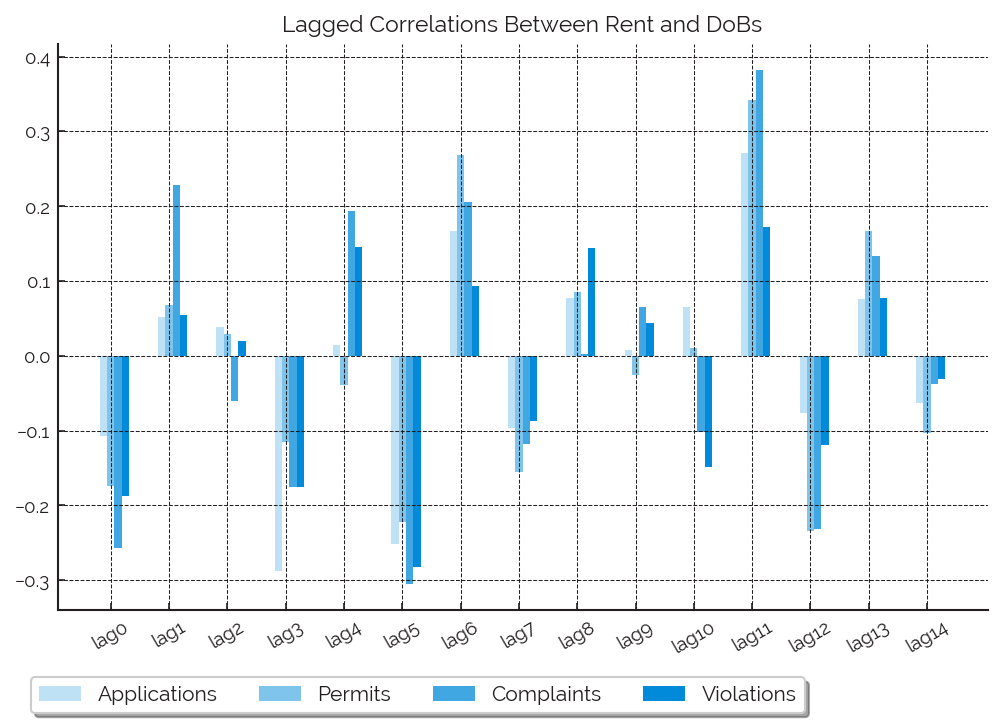

In [350]:
# The X position of bars
r1 = np.linspace(0,16*7,15)
r2 = np.linspace(0,16*7,15)+1
r3 = np.linspace(0,16*7,15)+2
r4 = np.linspace(0,16*7,15)+3
r5 = r1 + r2 + r3+r4
r = [r1,r2,r3,r4]
labels = ['Applications', 'Permits', 'Complaints', 'Violations']

plt.bar(r[0],corr_rent_df[corr_rent_df.columns[0]],color=ntblue,width = 1,alpha = .25,label =labels[0] )

for i,c in enumerate(corr_rent_df.columns[1:], 1):
    plt.bar(r[i],corr_rent_df[c],width = 1,color=ntblue,alpha =  .25 * (i + 1), label=labels[i]) 

t = plt.title('Lagged Correlations Between Rent and DoBs')
l = plt.legend(loc='center left', 
           bbox_to_anchor=(-0.04, -0.15),
           fancybox=True,
           shadow=True, 
           ncol=4)
g = plt.grid(axis="both", color=ntblack, linestyle="--")
tk = plt.xticks(r2, corr_rent_df.index , rotation=30)

In [351]:
lags = np.linspace(0,14,15).astype(int).tolist()
corr_ls =[]
for i in table_to_regression.columns[-2:]:
    lagged_column='rent'
    column= i
    corr = lagged_cross_corr_list(df=table_to_regression,column=column,lagged_column=lagged_column,lags = lags)
    corr_ls.append(corr)
corr_rent_penalty_df = pd.DataFrame(data=corr_ls).T

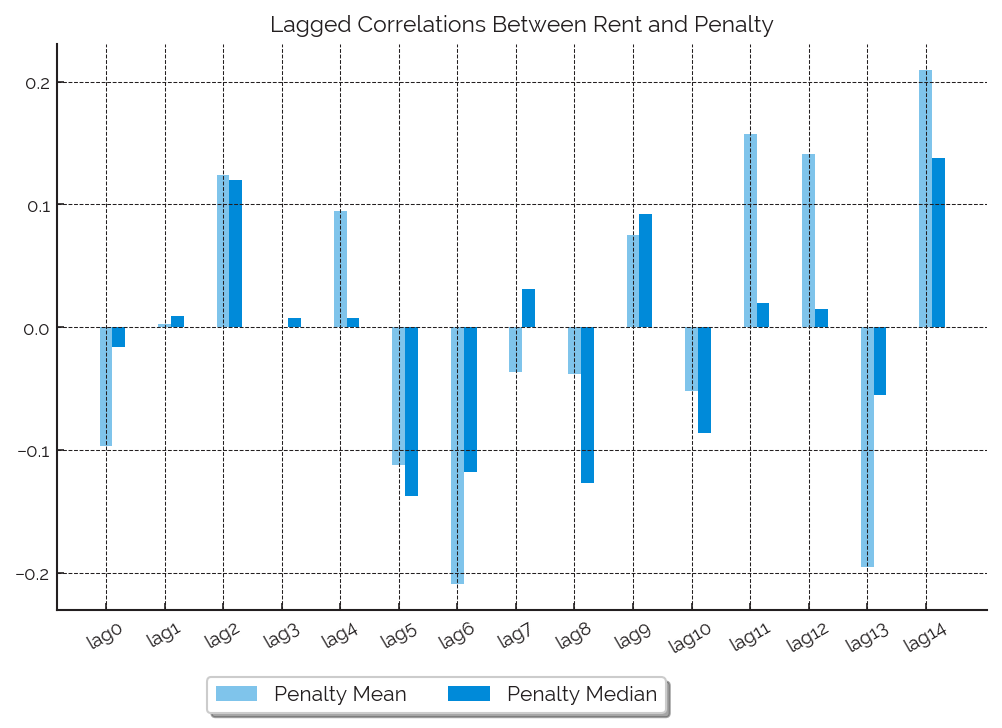

In [352]:
r1 = np.linspace(0,16*4,15)
r2 = np.linspace(0,16*4,15)+1
plt.bar(r1,corr_rent_penalty_df[corr_rent_penalty_df.columns[0]],color=ntblue,width = 1,alpha = .5,label = 'Penalty Mean')
plt.bar(r2,corr_rent_penalty_df[corr_rent_penalty_df.columns[1]],color=ntblue,width = 1,alpha = 1,label ='Penalty Median' )

t = plt.title('Lagged Correlations Between Rent and Penalty')
l = plt.legend(loc='center left', 
           bbox_to_anchor=(0.15, -0.15),
           fancybox=True,
           shadow=True, 
           ncol=2)
g = plt.grid(axis="both", color=ntblack, linestyle="--")
tk = plt.xticks(r1, corr_rent_penalty_df.index , rotation=30)

## 5. Correlations between sales and DoBs

In [353]:
lags = [1,3,5,7,9,11,13,15,17]
lagged_column='sales_price'
column='violations'
corr = lagged_cross_corr(df=table_to_regression,column=column,lagged_column=lagged_column,lags = lags)
corr.style.background_gradient(cmap='coolwarm')

,violations,sales_price,lag1_sales_price,lag3_sales_price,lag5_sales_price,lag7_sales_price,lag9_sales_price,lag11_sales_price,lag13_sales_price,lag15_sales_price,lag17_sales_price
violations,1,0.31302,-0.0718131,0.189865,0.0643414,0.0384336,0.159299,-0.142796,-0.311719,0.0105025,0.0848243
sales_price,0.31302,1,-0.377955,0.0417511,-0.0105612,-0.109793,0.062608,-0.158155,-0.245803,-0.0601685,0.0218152
lag1_sales_price,-0.0718131,-0.377955,1,0.0489708,-0.173441,0.00720008,-0.105496,-0.019218,0.636614,0.185123,-0.179857
lag3_sales_price,0.189865,0.0417511,0.0489708,1,0.025653,-0.183284,0.0207566,-0.0870084,-0.0306935,0.645066,0.1503
lag5_sales_price,0.0643414,-0.0105612,-0.173441,0.025653,1,0.0199571,-0.172284,0.0384618,-0.0986565,-0.0406062,0.637563
lag7_sales_price,0.0384336,-0.109793,0.00720008,-0.183284,0.0199571,1,0.0231706,-0.168868,0.0359583,-0.100147,-0.0513549
lag9_sales_price,0.159299,0.062608,-0.105496,0.0207566,-0.172284,0.0231706,1,0.0148869,-0.164845,0.0408306,-0.085717
lag11_sales_price,-0.142796,-0.158155,-0.019218,-0.0870084,0.0384618,-0.168868,0.0148869,1,0.0219727,-0.163629,0.069281
lag13_sales_price,-0.311719,-0.245803,0.636614,-0.0306935,-0.0986565,0.0359583,-0.164845,0.0219727,1,0.0200108,-0.181625
lag15_sales_price,0.0105025,-0.0601685,0.185123,0.645066,-0.0406062,-0.100147,0.0408306,-0.163629,0.0200108,1,0.0157612


In [354]:
column='complaints'
corr = lagged_cross_corr(df=table_to_regression,column=column,lagged_column=lagged_column,lags = lags)
corr.style.background_gradient(cmap='coolwarm')

,complaints,sales_price,lag1_sales_price,lag3_sales_price,lag5_sales_price,lag7_sales_price,lag9_sales_price,lag11_sales_price,lag13_sales_price,lag15_sales_price,lag17_sales_price
complaints,1,0.258462,-0.00343505,0.295647,0.178535,0.0811525,0.194404,-0.0537155,-0.0988708,0.111259,0.181045
sales_price,0.258462,1,-0.377955,0.0417511,-0.0105612,-0.109793,0.062608,-0.158155,-0.245803,-0.0601685,0.0218152
lag1_sales_price,-0.00343505,-0.377955,1,0.0489708,-0.173441,0.00720008,-0.105496,-0.019218,0.636614,0.185123,-0.179857
lag3_sales_price,0.295647,0.0417511,0.0489708,1,0.025653,-0.183284,0.0207566,-0.0870084,-0.0306935,0.645066,0.1503
lag5_sales_price,0.178535,-0.0105612,-0.173441,0.025653,1,0.0199571,-0.172284,0.0384618,-0.0986565,-0.0406062,0.637563
lag7_sales_price,0.0811525,-0.109793,0.00720008,-0.183284,0.0199571,1,0.0231706,-0.168868,0.0359583,-0.100147,-0.0513549
lag9_sales_price,0.194404,0.062608,-0.105496,0.0207566,-0.172284,0.0231706,1,0.0148869,-0.164845,0.0408306,-0.085717
lag11_sales_price,-0.0537155,-0.158155,-0.019218,-0.0870084,0.0384618,-0.168868,0.0148869,1,0.0219727,-0.163629,0.069281
lag13_sales_price,-0.0988708,-0.245803,0.636614,-0.0306935,-0.0986565,0.0359583,-0.164845,0.0219727,1,0.0200108,-0.181625
lag15_sales_price,0.111259,-0.0601685,0.185123,0.645066,-0.0406062,-0.100147,0.0408306,-0.163629,0.0200108,1,0.0157612


In [355]:
column='permits'
corr = lagged_cross_corr(df=table_to_regression,column=column,lagged_column=lagged_column,lags = lags)
corr.style.background_gradient(cmap='coolwarm')

,permits,sales_price,lag1_sales_price,lag3_sales_price,lag5_sales_price,lag7_sales_price,lag9_sales_price,lag11_sales_price,lag13_sales_price,lag15_sales_price,lag17_sales_price
permits,1,0.54849,-0.270798,0.373107,-0.043413,-0.0130165,0.222113,-0.122824,-0.389586,0.200044,0.00983524
sales_price,0.54849,1,-0.377955,0.0417511,-0.0105612,-0.109793,0.062608,-0.158155,-0.245803,-0.0601685,0.0218152
lag1_sales_price,-0.270798,-0.377955,1,0.0489708,-0.173441,0.00720008,-0.105496,-0.019218,0.636614,0.185123,-0.179857
lag3_sales_price,0.373107,0.0417511,0.0489708,1,0.025653,-0.183284,0.0207566,-0.0870084,-0.0306935,0.645066,0.1503
lag5_sales_price,-0.043413,-0.0105612,-0.173441,0.025653,1,0.0199571,-0.172284,0.0384618,-0.0986565,-0.0406062,0.637563
lag7_sales_price,-0.0130165,-0.109793,0.00720008,-0.183284,0.0199571,1,0.0231706,-0.168868,0.0359583,-0.100147,-0.0513549
lag9_sales_price,0.222113,0.062608,-0.105496,0.0207566,-0.172284,0.0231706,1,0.0148869,-0.164845,0.0408306,-0.085717
lag11_sales_price,-0.122824,-0.158155,-0.019218,-0.0870084,0.0384618,-0.168868,0.0148869,1,0.0219727,-0.163629,0.069281
lag13_sales_price,-0.389586,-0.245803,0.636614,-0.0306935,-0.0986565,0.0359583,-0.164845,0.0219727,1,0.0200108,-0.181625
lag15_sales_price,0.200044,-0.0601685,0.185123,0.645066,-0.0406062,-0.100147,0.0408306,-0.163629,0.0200108,1,0.0157612


In [356]:
column='applications'
corr = lagged_cross_corr(df=table_to_regression,column=column,lagged_column=lagged_column,lags = lags)
corr.style.background_gradient(cmap='coolwarm')

,applications,sales_price,lag1_sales_price,lag3_sales_price,lag5_sales_price,lag7_sales_price,lag9_sales_price,lag11_sales_price,lag13_sales_price,lag15_sales_price,lag17_sales_price
applications,1,0.539834,-0.33293,0.224602,0.0607187,-0.133789,0.0904455,-0.0309384,-0.417839,0.0228119,0.14312
sales_price,0.539834,1,-0.377955,0.0417511,-0.0105612,-0.109793,0.062608,-0.158155,-0.245803,-0.0601685,0.0218152
lag1_sales_price,-0.33293,-0.377955,1,0.0489708,-0.173441,0.00720008,-0.105496,-0.019218,0.636614,0.185123,-0.179857
lag3_sales_price,0.224602,0.0417511,0.0489708,1,0.025653,-0.183284,0.0207566,-0.0870084,-0.0306935,0.645066,0.1503
lag5_sales_price,0.0607187,-0.0105612,-0.173441,0.025653,1,0.0199571,-0.172284,0.0384618,-0.0986565,-0.0406062,0.637563
lag7_sales_price,-0.133789,-0.109793,0.00720008,-0.183284,0.0199571,1,0.0231706,-0.168868,0.0359583,-0.100147,-0.0513549
lag9_sales_price,0.0904455,0.062608,-0.105496,0.0207566,-0.172284,0.0231706,1,0.0148869,-0.164845,0.0408306,-0.085717
lag11_sales_price,-0.0309384,-0.158155,-0.019218,-0.0870084,0.0384618,-0.168868,0.0148869,1,0.0219727,-0.163629,0.069281
lag13_sales_price,-0.417839,-0.245803,0.636614,-0.0306935,-0.0986565,0.0359583,-0.164845,0.0219727,1,0.0200108,-0.181625
lag15_sales_price,0.0228119,-0.0601685,0.185123,0.645066,-0.0406062,-0.100147,0.0408306,-0.163629,0.0200108,1,0.0157612


In [357]:
column='penality_avg'
corr = lagged_cross_corr(df=table_to_regression,column=column,lagged_column=lagged_column,lags = lags)
corr.style.background_gradient(cmap='coolwarm')

,penality_avg,sales_price,lag1_sales_price,lag3_sales_price,lag5_sales_price,lag7_sales_price,lag9_sales_price,lag11_sales_price,lag13_sales_price,lag15_sales_price,lag17_sales_price
penality_avg,1,0.185561,0.0505347,-0.00144381,-0.0288553,0.0801926,-0.115556,-0.175237,0.0605063,0.116557,-0.121175
sales_price,0.185561,1,-0.377955,0.0417511,-0.0105612,-0.109793,0.062608,-0.158155,-0.245803,-0.0601685,0.0218152
lag1_sales_price,0.0505347,-0.377955,1,0.0489708,-0.173441,0.00720008,-0.105496,-0.019218,0.636614,0.185123,-0.179857
lag3_sales_price,-0.00144381,0.0417511,0.0489708,1,0.025653,-0.183284,0.0207566,-0.0870084,-0.0306935,0.645066,0.1503
lag5_sales_price,-0.0288553,-0.0105612,-0.173441,0.025653,1,0.0199571,-0.172284,0.0384618,-0.0986565,-0.0406062,0.637563
lag7_sales_price,0.0801926,-0.109793,0.00720008,-0.183284,0.0199571,1,0.0231706,-0.168868,0.0359583,-0.100147,-0.0513549
lag9_sales_price,-0.115556,0.062608,-0.105496,0.0207566,-0.172284,0.0231706,1,0.0148869,-0.164845,0.0408306,-0.085717
lag11_sales_price,-0.175237,-0.158155,-0.019218,-0.0870084,0.0384618,-0.168868,0.0148869,1,0.0219727,-0.163629,0.069281
lag13_sales_price,0.0605063,-0.245803,0.636614,-0.0306935,-0.0986565,0.0359583,-0.164845,0.0219727,1,0.0200108,-0.181625
lag15_sales_price,0.116557,-0.0601685,0.185123,0.645066,-0.0406062,-0.100147,0.0408306,-0.163629,0.0200108,1,0.0157612


In [358]:
lags = np.linspace(0,14,15).astype(int).tolist()
corr_ls =[]
for i in table_to_regression.columns[:4]:
    lagged_column='sales_price'
    column= i
    corr = lagged_cross_corr_list(df=table_to_regression,column=column,lagged_column=lagged_column,lags = lags)
    corr_ls.append(corr)


In [359]:
corr_sales_df = pd.DataFrame(data=corr_ls).T

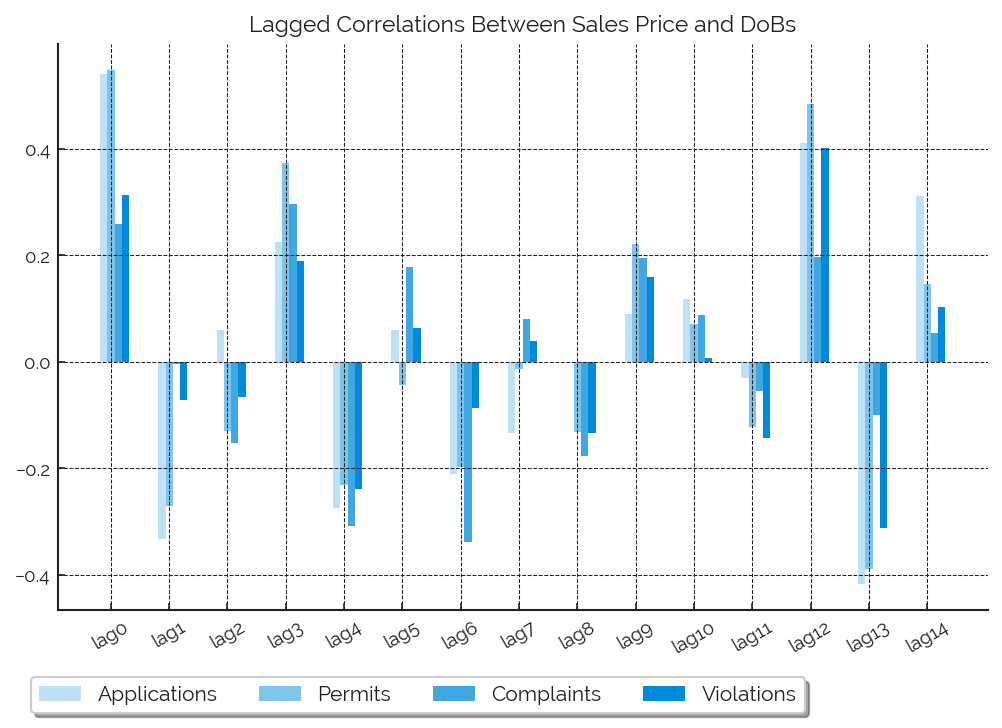

In [360]:
# The X position of bars
r1 = np.linspace(0,16*7,15)
r2 = np.linspace(0,16*7,15)+1
r3 = np.linspace(0,16*7,15)+2
r4 = np.linspace(0,16*7,15)+3
r5 = r1 + r2 + r3+r4
r = [r1,r2,r3,r4]

plt.bar(r[0],corr_sales_df[corr_sales_df.columns[0]],color=ntblue,width = 1,alpha = .25,label =labels[0] )

for i,c in enumerate(corr_sales_df.columns[1:], 1):
    plt.bar(r[i],corr_sales_df[c],width = 1,color=ntblue,alpha =  .25 * (i + 1), label=labels[i]) 

t = plt.title('Lagged Correlations Between Sales Price and DoBs')
l = plt.legend(loc='center left', 
           bbox_to_anchor=(-0.04, -0.15),
           fancybox=True,
           shadow=True, 
           ncol=4)
g = plt.grid(axis="both", color=ntblack, linestyle="--")
tk = plt.xticks(r2, corr_sales_df.index , rotation=30)

In [361]:
lags = np.linspace(0,14,15).astype(int).tolist()
corr_ls =[]
for i in table_to_regression.columns[-2:]:
    lagged_column='sales_price'
    column= i
    corr = lagged_cross_corr_list(df=table_to_regression,column=column,lagged_column=lagged_column,lags = lags)
    corr_ls.append(corr)
corr_sales_penalty_df = pd.DataFrame(data=corr_ls).T

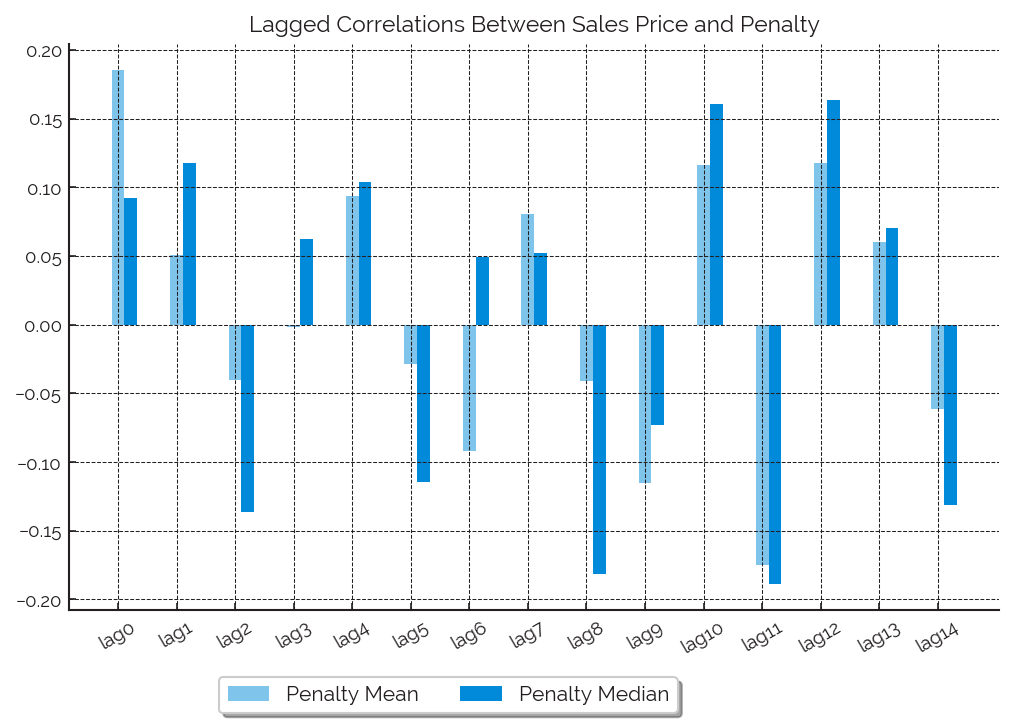

In [362]:
r1 = np.linspace(0,16*4,15)
r2 = np.linspace(0,16*4,15)+1
plt.bar(r1,corr_sales_penalty_df[corr_sales_penalty_df.columns[0]],color=ntblue,width = 1,alpha = .5,label = 'Penalty Mean')
plt.bar(r2,corr_sales_penalty_df[corr_sales_penalty_df.columns[1]],color=ntblue,width = 1,alpha = 1,label ='Penalty Median' )

t = plt.title('Lagged Correlations Between Sales Price and Penalty')
l = plt.legend(loc='center left', 
           bbox_to_anchor=(0.15, -0.15),
           fancybox=True,
           shadow=True, 
           ncol=2)
g = plt.grid(axis="both", color=ntblack, linestyle="--")
tk = plt.xticks(r1, corr_sales_penalty_df.index , rotation=30)

# 6. Regression analysis

In [363]:
corr_rent_penalty_df.idxmax(axis = 0)

penality_avg    lag14
penality_med    lag14
dtype: object

In [364]:
corr_rent_df.idxmax(axis=0)

applications    lag11
permits         lag11
complaints      lag11
violations      lag11
dtype: object

In [365]:
corr_rent_df.max(axis=0)

applications    0.271103
permits         0.342315
complaints      0.382376
violations      0.172104
dtype: float64

In [366]:
corr_rent_df.abs().idxmax(axis=0)

applications     lag3
permits         lag11
complaints      lag11
violations       lag5
dtype: object

In [367]:
corr_rent_df.abs().max(axis=0)

applications    0.287365
permits         0.342315
complaints      0.382376
violations      0.281856
dtype: float64

### A Manhattan only regression analysis

In [24]:
table_to_regression.head()

,applications,permits,complaints,violations,sales_price,rent,penality_avg,penality_med
data_labels,,,,,,,,
2010-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-2,0.015490,-0.052672,-0.128682,-0.508951,-0.073473,-0.001786,0.213726,0.600
2010-3,0.438762,0.525261,0.274021,0.575000,0.154480,-0.026476,0.103255,0.000
2010-4,0.032117,0.008062,-0.074488,-0.048280,0.074933,0.029033,-0.002733,0.000
2010-5,-0.121752,-0.233832,-0.030181,-0.138985,-0.073859,0.000000,-0.220772,-0.375


In [44]:
table_to_regression_test= table_to_regression.drop(columns=['sales_price','penality_med'])

In [45]:
table_to_regression_test= table_to_regression_test.iloc[1:]

In [46]:
table_to_regression_test.applications  = table_to_regression_test.applications.shift(3)
table_to_regression_test.permits  = table_to_regression_test.permits.shift(11)
table_to_regression_test.complaints  = table_to_regression_test.complaints.shift(11)
table_to_regression_test.violations  = table_to_regression_test.violations.shift(5)

In [47]:
# variables = ['applications','permits','complaints','violations','penality_avg']
variables = ['applications','permits','complaints','violations']
# variables = ['permits','violations','penality_avg']
# variables = ['permits','violations']
# variables = ['permits','penality_avg']
# variables = ['penality_avg']

In [48]:
table_to_regression_test.head()

,applications,permits,complaints,violations,rent,penality_avg
data_labels,,,,,,
2010-2,NaN,NaN,NaN,NaN,-0.001786,0.213726
2010-3,NaN,NaN,NaN,NaN,-0.026476,0.103255
2010-4,NaN,NaN,NaN,NaN,0.029033,-0.002733
2010-5,0.015490,NaN,NaN,NaN,0.000000,-0.220772
2010-6,0.438762,NaN,NaN,NaN,0.007143,0.568613


In [52]:
X = table_to_regression_test[variables].iloc[11:]

In [54]:
y = table_to_regression_test['rent'].iloc[11:]

In [60]:
train = slice("2014-1", "2015-12")

In [61]:
test = slice("2016-1", "2016-7")

In [63]:
reg = LinearRegression().fit(X.loc[train], y.loc[train])

In [65]:
reg.score(X.loc[test], y.loc[test])

-0.34056555645218256

In [67]:
y_pred = pd.DataFrame(reg.predict(X.loc[test]), index=X.loc[test].index, columns=["y_pred"])

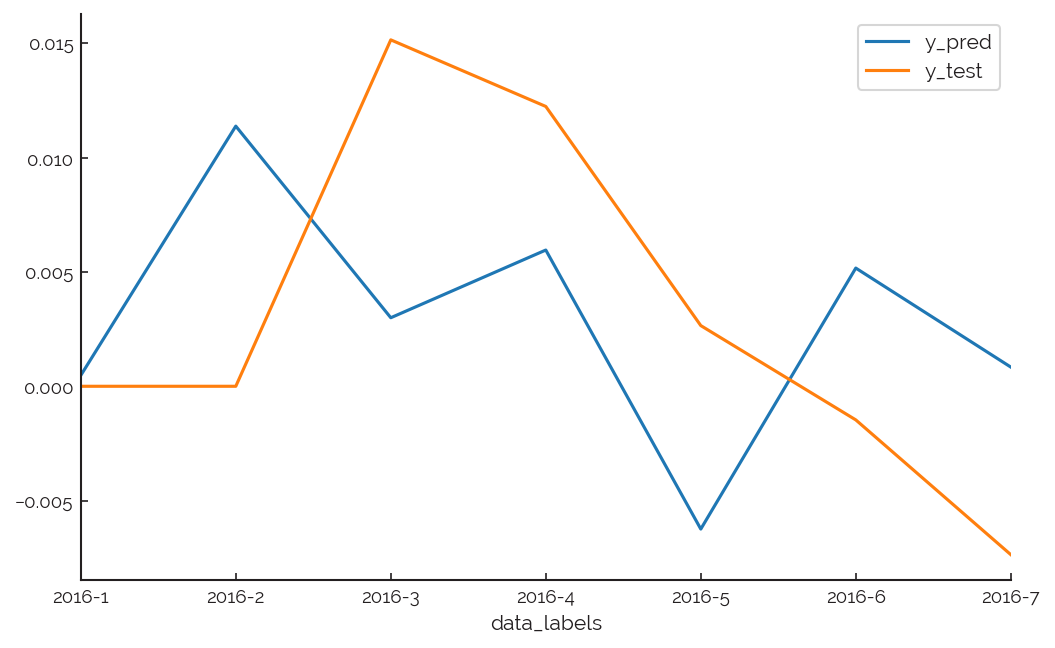

In [70]:
y_pred.join(y.loc[test].rename("y_test")).plot()